# Introduction to control theory. 

## TP5. State Observers. LQ.
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP4.ipynb)    

The completed notebooks should be sent to your tutor (elena.vanneaux@ensta.fr or adnan.saood@ensta.fr) before the beginning of the next session. Please add [APM_4AUT2_TA] to the topic of e-mail.

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html




## TODO

Last time you have designed a full-state feedback controller $u=-Kx, $ which stabilize the system in steady state
$x = (0,0,0,0).$

0. If you haven't done this - do it today! And don't hesitate to ask questions if it is unclear.

This time let us assume that we only measure the position and the angular velocity, while their derivatives are not availabe. I.e. $y_{output} = (y, \theta)' = Cx,$ where 
$$C = \begin{pmatrix} 1 & 0 & 0 &0 \\ 0 & 0 & 1 &0 \end{pmatrix}$$

1. Is pair of matrices (A,C) observable? Why is it important? 

2. For an atonomus system
$$
\dot x = Ax, \ y = Cx
$$

design an observer $$\dot{\hat{x}} = (A - LC)\hat{x} + Ly,$$ such that the estimation of the state $\hat{x}$ converges to real state $x$. To do that we need to find a matrice $L$ such that the matrice $A-LC$ is Hurwits (i.e. all it eiginevalues have negative real part). 

Remark: to place arbitary eigenvalues $\lambda_1,\ldots \lambda_n$ in matrice (A - LC) with matrice L, it is the same as to place $\lambda_1,\ldots \lambda_n$ in matrice $(A^T - C^TL^T)$ with matrice $L^T$. 

Plot a real trajectory $x$ strarting from the point $x_0 = (2,0,1,0)$ and its estimation $\hat{x}$ strating from the point $\hat{x}_0 = (3,-1,2,0.5)$ to show convergence.

3. Design an optimal estimator (LQE) and optimal estimated state feedback controller (LQR) which stabilize the system in (0,0,0,0).

Remark: See slide "observer and controller" in the lecture.

### Question 0
Here is the controller designed last time.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import control as ctr

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T)  

In [8]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = np.zeros((2,1))

sys = ctr.ss(A, B, C, D)

### Question 1
Let's test is the system is observable.

In [9]:
obsv_m = ctr.obsv(sys.A, sys.C)
C_rank = np.linalg.matrix_rank(obsv_m)

if C_rank==4:
    print("System is observable.")

System is observable.


### Question 2 
Now, let's design an observer such that the observation of the state converges to the real state, ie : $\dot{\hat{x}} = (A - LC)\hat{x} + Ly,$
We need to find a matrice $L$ such that the matrice $A-LC$ is Hurwits. The slides tell us that the matrix $K^T$ is the best one, so let's use it. 

In [5]:
K = ctr.place(A, B, [-1, -2, -3, -4])

A_2 = A - np.dot(B, K)

L = np.transpose(K)

def system_dynamics(t, x):
    return A @ x

def observer_dynamics(t, x_hat, x_real):
    y = C @ x_real
    return (A - L @ C) @ x_hat + L @ y

x0_real = np.array([2, 0, 1, 0])
x0_hat = np.array([3, -1, 2, 0.5])
tf = 6
T = np.linspace(t0, tf, 1000)

#solution = OpenLoopInputOutputSystem(A_2, B, np.zeros_like(B), np.eye(4), lambda t: 0, lambda t: 0, T, x0)

(4, 1000)


Text(0, 0.5, 'Position ')

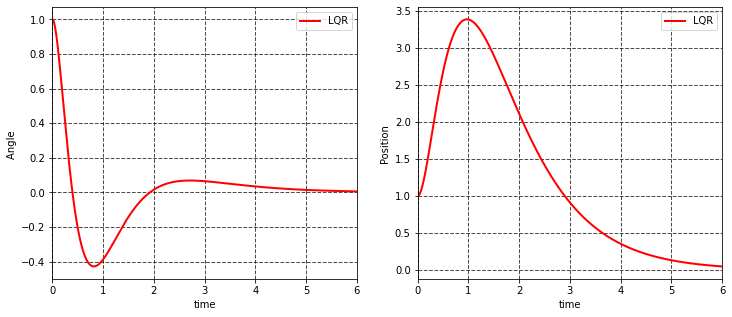

In [6]:
figure(figsize=(12, 5))
y = solution[2, :]
print(solution.shape)

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['LQR' ])
ylabel(r'Angle ')

y = solution[0, :]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['LQR' ])
ylabel(r'Position ')